# Loop transfer-function measurement example

In this notebook, we measure the transfer-function of the feedback-loop implemented in example2_pdh_generation and example3_lock_acquisition_sequence

In [1]:
# Set environment variable to use a custom configuration file location
import os
os.environ["PYRPL_USER_DIR"] = "../pyrpl_user_dir/"

In [2]:
from pyrpl import Pyrpl, logger, logging
logging.disable(logging.WARNING) # Make the program less verbose
# Open an existing config file to start from the previous working state
p = Pyrpl("loop_measurement_example") 

C:\Users\OMQ SQZ 2.0\.conda\envs\Nospace\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
p_shg = Pyrpl('shg_test') # We use a second redpitaya to measure an out-of-loop error signal
p_shg.lockbox0.lock()

True

## Define lockbox inputs, outputs and lock sequence 

In [11]:
from pyrpl.software_modules.lockbox.models.fabryperot import FabryPerot, LockboxModuleDictProperty, PiezoOutput

    
p.lockbox.classname = "FabryPerot"
# classes heriting from Lockbox can be chosen as "classname"

lockbox = p.lockbox
lockbox.unlock()

## parameters of the physical model
lockbox.eta = 0.84 # mode matching
lockbox.wavelength = 532e-9
lockbox.finesse = 9
lockbox.round_trip_length = 0.27

## Configure inputs
# transmission 
trans = lockbox.inputs.transmission # actually transmission from infrared beam
trans.input = 'in1'

refl = lockbox.inputs.reflection
refl.input = 'in2'

# pdh
pdh = lockbox.inputs.pdh
# The IQ module is configured by the lockbox (see example2_pdh_generation for details)
pdh.mod_amp = 1.
pdh.mod_freq = 21e6
pdh.quadrature_factor = 10
pdh.bandwidth = [6.5e5, 6.5e5] # second-order lowpass filter
pdh.mod_phase = 180
pdh.mod_output = 'out1'
pdh.input_signal = 'in2' # reflection

## configure outputs
# piezo
piezo = lockbox.outputs.piezo
piezo.sweep_amplitude = 1.
piezo.sweep_frequency = 10.
piezo.sweep_waveform = "ramp"
piezo.output_channel = 'out2'
piezo.tf_type = 'flat'

piezo.assisted_design = False
piezo.dc_gain = 250e-9 # in m/V
piezo.p = 15 # open-loop proportional gain (oscillates at 20)
piezo.i = 1500 # open-loop integral unity-gain frequency (corner frequency at 100 Hz)


## configure the LockSequence
sequence = p.lockbox.sequence

# remove all stages in the sequence (except for the first)
while len(p.lockbox.sequence)>1:
    p.lockbox.sequence.remove(p.lockbox.sequence[-1])

# configure first stage
stage0 = p.lockbox.sequence[0]
stage0.outputs.piezo.lock_on = False # Can be either True, False, or "ignore"
stage0.outputs.piezo.reset_offset = True # reset integrator offset at 1 V
stage0.outputs.piezo.offset = -1.


# Create and configure second stage
sequence.append({})
stage1 = p.lockbox.sequence[1]
stage1.input = 'transmission'
stage1.setpoint = -0.5 # in units of cavity linewidth
stage1.duration = 0.5 # time before switching to next stage
stage1.gain_factor = -0.01 # Gain to apply compared to output transfer function
stage1.outputs.piezo.reset_offset = True
stage1.outputs.piezo.offset = -0.7
stage1.outputs.piezo.lock_on = True

# Create and configure third stage
sequence.append({})
stage2 = p.lockbox.sequence[2]
stage2.input = 'pdh'
stage2.setpoint = 0 # in units of cavity linewidth
stage2.gain_factor = 1. # Gain to apply compared to output transfer function
stage2.duration = 0.5
stage2.outputs.piezo.reset_offset = False
stage2.outputs.piezo.lock_on = True

In [12]:
## Calibrate inputs

p.lockbox.calibrate_all()

[]

## Lock the cavity

In [13]:
p.lockbox.lock() # do lock the cavity

True

If the locking sequence worked well, the traces on the scope should look like the following: 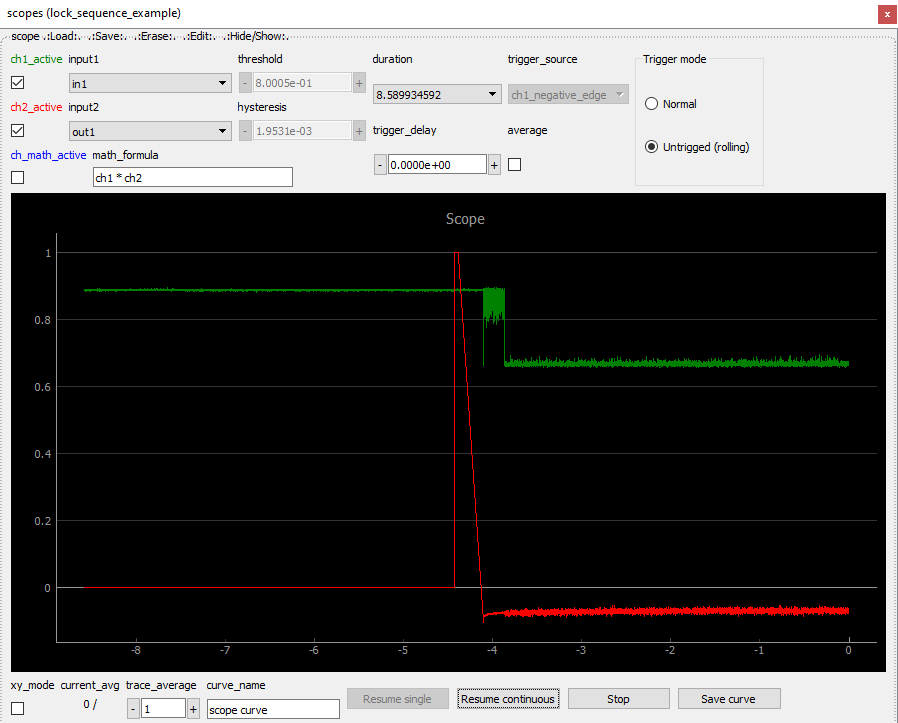

## Define functions for loop measurements and plotting

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from pyrpl.async_utils import sleep

def bode_plot(freqs, zs, axes=None, label=None, color=None, linestyle=None):
    """
    Plots the magnitude and phase of a complex series.
    """
    if axes is None:
        fig, axes = plt.subplots(2, 1, sharex=True)
    axes[0].semilogx(freqs, 20*np.log10(np.abs(zs)), linestyle=linestyle, color=color, label=label)
    axes[1].semilogx(freqs, 180/np.pi*np.angle(zs), linestyle=linestyle, color=color, label=label)
    #axes[0].set_xticklabels([])
    plt.setp(axes[0].get_xticklabels(), visible=False)
    axes[1].set_ylim(-200, 200)
    axes[1].set_yticks([-180, -90, 0, 90, 180])
    axes[1].set_xlabel("Frequency (Hz)")
    axes[0].set_ylabel("Amplitude (dB)")
    axes[1].set_ylabel(r"Phase ($^\circ$)")

    #axes[0].set_yticks([-120, -60, 0, 60, 120])
    axes[1].set_yticks([-180, -90, 0, 90, ])
    axes[0].tick_params(axis='x', which='minor', bottom=True)
    axes[1].tick_params(axis='x', which='minor', bottom=True)
    axes[0].grid(True)
    axes[1].grid(True)
    plt.subplots_adjust(hspace=0.2, top=0.93)
    return axes

def current_output():
    """find which output is locked"""
    if p.lockbox.current_stage=='unlock':
        raise(ValueError("Lockbox unlocked"))
    for output in p.lockbox.current_stage.outputs:
        if(output.lock_on):
            return getattr(p.lockbox.outputs, output.name)

def measure_closed_loop(start_freq=10, stop_freq=1e6, points=300, rbw=75, average_per_point=1, q_factor_min=20,
                        is_plot=True, amplitude_start=0.2, is_auto_amplitude=True):
    """
    This function measures the closed-loop transfer function by connecting the network analyzer's output_direct
    to out1. This adds a sinusiodal modulation to the plant, which gets partly cancelled by the feedback-loop at
    frequencies where the open-loop gain is large. The network analyzer's input, set to 'out1' as well, is given
    by the sum of the network analyzer modulation, and controller response.
    
    amplitude_start is the modulation at the beginning of the scan.

    is_auto_amplitude can be used to maintain a constant error signal modulation throughout the network analyzer 
    scan, in spite of the large differences in loop gain as a function of frequency.
    
    q_factor_min is used with the auto_bandwidth function of the network_analyzer to reduce the measurement 
    bandwidth at low frequency.
    """
    p.networkanalyzer.output_direct = "out2"
    p.networkanalyzer.input = "out2"
    p.networkanalyzer.acbandwidth = 4
    p.networkanalyzer.logscale = True
    p.networkanalyzer.trace_average = 1
    p.networkanalyzer.average_per_point = average_per_point
    p.networkanalyzer.points = points

    p.networkanalyzer.start_freq = start_freq # 2e4
    p.networkanalyzer.stop_freq = stop_freq # 5e5

    p.networkanalyzer.auto_bandwidth = True
    p.networkanalyzer.q_factor_min = q_factor_min
    p.networkanalyzer.rbw = rbw

    p.networkanalyzer.amplitude = amplitude_start #0.2 
    p.networkanalyzer.auto_amplitude = is_auto_amplitude
    p.networkanalyzer.target_dbv = -40
    p.networkanalyzer.auto_amp_min = 0.001
    p.networkanalyzer.auto_amp_max = 0.2
    
    freqs = p.networkanalyzer.frequencies
    closed_loop_tf = p.networkanalyzer.single()
    try:
        current_output()
    except ValueError: 
        controller_tf = None
    else:
        controller_tf = current_output().transfer_function_controller(freqs, p.lockbox.current_stage)
    return freqs, closed_loop_tf, controller_tf


def measure_loop_tf_and_background(start_freq_tf=30, stop_freq_tf=5e5,
            points_tf=500, q_factor_min=5, rbw=5, avg_per_point=1, start_amp=None):
    """
    For accurate results at high frequency, where the open-loop gain is small, it is advisable to normalize 
    the closed-loop transfer function with the background transfer function (transfer function measured 
    without pdh modulation). This efficiently captures the various analog crosstalks and digital delay in 
    the output summators.
    """
    
    slope_bw_per_v = p.lockbox.inputs.pdh.expected_slope(0)  
    
    # MEASURE TRANSFER FUNCTION
    if start_amp is None:
        start_amp = min(10**(-55/10)*np.abs(p.lockbox.outputs.piezo.transfer_function([start_freq_tf]))[0], 0.2)
    
    freqs_tf, closed_loop_tf, controller_tf = \
    measure_closed_loop(start_freq=start_freq_tf, stop_freq=stop_freq_tf, rbw=rbw, points=points_tf, 
                        amplitude_start=start_amp, 
                        q_factor_min=q_factor_min, average_per_point=avg_per_point)
    
    final_amplitude = p.networkanalyzer.amplitude_list[-1]
    
    # MEASURE BACKGROUND TRANSFER FUNCTION (cross-talk without pdh modulation)
    old_amp = p.lockbox.inputs.pdh.mod_amp
    out = p.lockbox.outputs.piezo
    old_filter = out.additional_filter
    out.additional_filter = old_filter[:3] + [-1] # add a high-pass filter to avoid saturation during background measurement
    p.lockbox.inputs.pdh.mod_amp = 0
    sleep(5) # wati 5 s for filter to set up
    # reset offset to 0 to make sure no saturation occurs during background measurement 
    out.ival = 0
    
    
    freqs_tf_bg, tf_bg, _ = \
    measure_closed_loop(start_freq=start_freq_tf, stop_freq=stop_freq_tf, rbw=rbw, points=100, q_factor_min=q_factor_min,
                        amplitude_start=final_amplitude, average_per_point=avg_per_point, is_auto_amplitude=False)

    p.lockbox.inputs.pdh.mod_amp = old_amp
    out.additional_filter = old_filter

    
    return dict(freqs_tf=freqs_tf, closed_loop_tf=closed_loop_tf, controller_tf=controller_tf, 
                slope_bw_per_v=slope_bw_per_v, background_correction=(freqs_tf_bg, tf_bg))


def get_open_loop_and_plant(freqs_tf, closed_loop_tf, controller_tf, background_correction='delay', **kwds):
    if background_correction=="delay":
        closed_loop_tf_corr = closed_loop_tf*np.exp(-1j*2*np.pi*freqs_tf*8e-9*5)
    elif background_correction is not None:
        freqs_corr, corr = background_correction
        freqs_corr = np.real(freqs_corr)
        corr = np.interp(freqs_tf, freqs_corr, corr)
        closed_loop_tf_corr = closed_loop_tf/corr # Compensate delay of output summator
    else:
        closed_loop_tf_corr = closed_loop_loaded
         
    open_loop_tf = 1 - 1./closed_loop_tf_corr
    plant_tf = open_loop_tf/controller_tf
    
    return open_loop_tf, plant_tf

def plot_loop_tfs(freqs_tf, closed_loop_tf, controller_tf, background_correction='delay', 
                  gain_margin=None, phase_margin=None, axes=None, 
                  is_plot_plant=True,
                  is_plot_controller=True,
                  **kwds):
    """
    Calculate and plots the following transfer-function:
      - closed loop corrected (correct for output sumator tf)
      - open loop (1 - 1/closed_loop_corrected)
      - controller (user provided)
      - plant (deduced from plant = open_loop/controller)
      
    background_correction can be 'delay' (take into account the 5 cycles of delay at the sumator), or
    a npy filename containing measured sumator transfer function (freqs_corr, corr)
    """
    open_loop_tf, plant_tf = get_open_loop_and_plant(freqs_tf, closed_loop_tf, controller_tf, background_correction=background_correction)
        
    
    axes = bode_plot(freqs_tf, open_loop_tf, label='open-loop', axes=axes)
    if is_plot_controller:
        bode_plot(freqs_tf, controller_tf*1e-2, axes=axes, label='controller', linestyle='--')
    bode_plot(freqs_tf, closed_loop_tf, axes=axes, label='closed-loop')
    if is_plot_plant:
        bode_plot(freqs_tf, plant_tf, axes=axes, label='plant')
    # Add plot legend
    axes[0].legend(ncol=2, bbox_to_anchor=(0.73, -0.26), loc='lower right')
    axes[0].set_zorder(100)
    
    if gain_margin is not None:
        gain_margin_val, gain_margin_freq = gain_margin
        axes[0].plot([min(freqs_tf), gain_margin_freq], [0]*2, 'k')
        axes[0].plot([gain_margin_freq, gain_margin_freq], [0, 20*np.log10(gain_margin_val)], 'k')
        axes[0].plot([gain_margin_freq], [20*np.log10(gain_margin_val)], 'og')
    if phase_margin is not None:
        phase_margin_val, phase_margin_freq = phase_margin
        axes[1].plot([min(freqs_tf), phase_margin_freq], [0]*2, 'k')
        axes[1].plot([phase_margin_freq, phase_margin_freq], [0, 180/np.pi*phase_margin_val], 'k')
        axes[1].plot([phase_margin_freq], [180/np.pi*phase_margin_val], 'or')
    return open_loop_tf, plant_tf

def plot_nyquist_diagram(freqs, open_loop_tf, min_freq=1e4, max_freq=1e6, ax=None):
    mask = (freqs<max_freq)*(freqs>min_freq)
    if ax is None:
        ax = plt.figure()
    ax.plot(np.real(open_loop_tf[mask]), np.imag(open_loop_tf[mask]), '-')
    gain_margin_amp = 1e-100
    gain_margin_phase = 0
    gain_margin_freq = 0

    phase_margin = 2*np.pi
    phase_margin_amp = 0
    phase_margin_freq = 0
    for index in range(len(freqs[mask])-1):
        ol_masked = open_loop_tf[mask]
        z = ol_masked[index]
        znext = ol_masked[index + 1]
        if phase_margin_freq==0:
            if (np.abs(znext)<1) and (np.abs(z)>1): # crossing unit circle
                if (np.angle(z) > 0): # and (np.angle(z) < min_crossing_phase):
                    weight1, weight2 = (np.abs(z) - 1)/(np.abs(z) - np.abs(znext)), -(np.abs(znext) - 1)/(np.abs(z) - np.abs(znext))
                    point = weight2*z + weight1*znext
                    phase_margin = np.angle(point)
                    phase_margin_amp = 1 # by definition
                    phase_margin_freq = weight2*freqs[mask][index] + weight1*freqs[mask][index + 1]
        if (np.angle(znext)<0) and (np.angle(z)>0): # crossing real axis
            weight1, weight2 = np.imag(z)/(np.imag(z) - np.imag(znext)), -np.imag(znext)/(np.imag(z) - np.imag(znext))
            crossing_value = np.real(weight2*z + weight1*znext)
            if crossing_value>gain_margin_amp and crossing_value<1:
                gain_margin_amp = crossing_value
                gain_margin_phase = 0 # by definition
                gain_margin_freq = weight2*freqs[mask][index] +  weight1*freqs[mask][index + 1]


    z_crossing_real = gain_margin_amp*np.exp(1j*gain_margin_phase)
    z_crossing_circle = phase_margin_amp*np.exp(1j*phase_margin)
    #plt.annotate(f"f = {max_crossing_freq:.0f} Hz", (np.real(z_crossing_real), np.imag(z_crossing_real)))
    ax.plot([np.real(z_crossing_real)], [np.imag(z_crossing_real)], 'og', 
             label=f"gain margin: x {1./gain_margin_amp:.2f} @ {gain_margin_freq:.0f} Hz")
            # {20*np.log10(1./gain_margin_amp):.2f} dB (=
    ax.plot([np.real(z_crossing_circle)], [np.imag(z_crossing_circle)], 'or', 
             label=f"phase margin: {phase_margin*180/np.pi:.1f}$^\circ$ @ {phase_margin_freq:.0f} Hz")
    ax.legend()
    thetas = np.linspace(0, 2*np.pi, 1000)
    ax.plot(np.sin(thetas), np.cos(thetas), ':k')
    ax.plot([0, 2], [0, 0], ':k')
    NYQUIST_PLOT_LIM = 1.5
    ax.set_xlabel("Re(open loop tf)")
    ax.set_ylabel("Im(open loop tf)")

    ax.set_xlim(-NYQUIST_PLOT_LIM, NYQUIST_PLOT_LIM)
    ax.set_ylim(-NYQUIST_PLOT_LIM, NYQUIST_PLOT_LIM)
    ax.set_aspect("equal")
    return (z_crossing_real, gain_margin_freq), (z_crossing_circle, phase_margin_freq)

def analyze_loop_tf(freqs_tf, closed_loop_tf, controller_tf, background_correction, nyquist_min_freq=100, 
                    is_plot_plant=True, is_plot_controller=True, **kwds):
    fig = plt.figure(constrained_layout=True, figsize=(14, 4))
    gs = fig.add_gridspec(2, 10)
    ax_mag = fig.add_subplot(gs[0, :7])
    ax_phase = fig.add_subplot(gs[1, :7], sharex=ax_mag)
    ax_nyquist = fig.add_subplot(gs[:, 7:])
    #ax_spectra = fig.add_subplot(gs[12:, 1:])

    bg_tuple = background_correction #(data.freqs_tf_bg, data.tf_bg)

    open_loop_tf, plant_tf = get_open_loop_and_plant(freqs_tf, closed_loop_tf, controller_tf, background_correction=bg_tuple)
    (gain_margin_z, gain_margin_freq), (phase_margin_z, phase_margin_freq) = plot_nyquist_diagram(freqs_tf, 
                                                                                                  open_loop_tf, 
                                                                                                  ax=ax_nyquist,
                                                                                                  min_freq=nyquist_min_freq)
    open_loop_tf, plant_tf = plot_loop_tfs(freqs_tf, 
                                           closed_loop_tf=closed_loop_tf, 
                                           controller_tf=controller_tf, 
                                           phase_margin=(np.angle(phase_margin_z), phase_margin_freq),
                                           gain_margin=(np.abs(gain_margin_z), gain_margin_freq),
                                           axes=[ax_mag, ax_phase], 
                                           background_correction=bg_tuple,
                                           is_plot_plant=is_plot_plant,
                                           is_plot_controller=is_plot_controller)
    """
    FINESSE = 9
    WAVELENGTH = 532e-9
    BW_IN_M = WAVELENGTH/2/FINESSE/2

    plot_loop_spectra(freqs_psd, data.psd_pdh, data.psd_output, 
                      slope_m_per_v=data.slope_bw_per_v*BW_IN_M,
                      freqs_closed_loop_tf=data.freqs_tf[1:],
                      closed_loop_tf=data.closed_loop_tf[1:],
                      controller_tf=data.controller_tf[1:],
                      ax=ax_spectra)
    plt.suptitle(f"Loop , gain_factor={data.gain_factor:.3e}")
    """
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)
    
    return fig

## Measure loop transfer function

In [23]:
START_FREQ = 10
STOP_FREQ = 5e5
Q_FACTOR_MIN = 5
RBW = 5
POINTS = 30000
AVG_PER_POINT = 1
AMPLITUDE_START = 0.3

kwds = measure_loop_tf_and_background(start_freq_tf=START_FREQ, 
                                      stop_freq_tf=STOP_FREQ, 
                                      q_factor_min=Q_FACTOR_MIN, 
                                      rbw=RBW, 
                                      points_tf=POINTS,
                                      avg_per_point=AVG_PER_POINT,
                                      start_amp=AMPLITUDE_START)

C:\Users\OMQ SQZ 2.0\.conda\envs\Nospace\lib\site-packages\pyqtgraph\graphicsItems\AxisItem.py:817: RuntimeWarning: overflow encountered in power
  estrings = ["%0.1g"%x for x in 10 ** np.array(values).astype(float) * np.array(scale)]


In [26]:
import h5py

with h5py.File("./data/data.h5", 'w') as f:
    for key, value in kwds.items():
        dset = f.create_dataset(key, data=value)

C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_16424\2086638708.py:26: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.2, top=0.93)


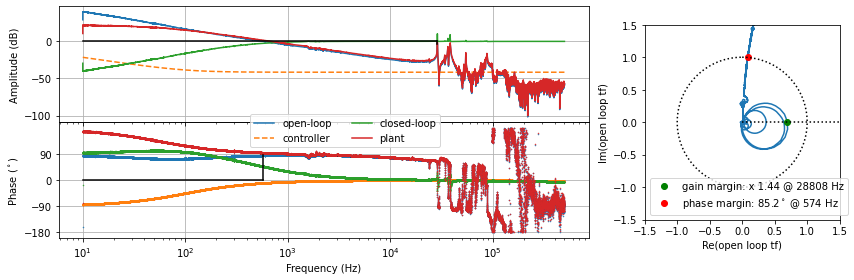

In [25]:
fig = analyze_loop_tf(**kwds, nyquist_min_freq=200)

During the acquisition, one can check that the loop stays locked, eventhough the network analyzer modulates "out2": 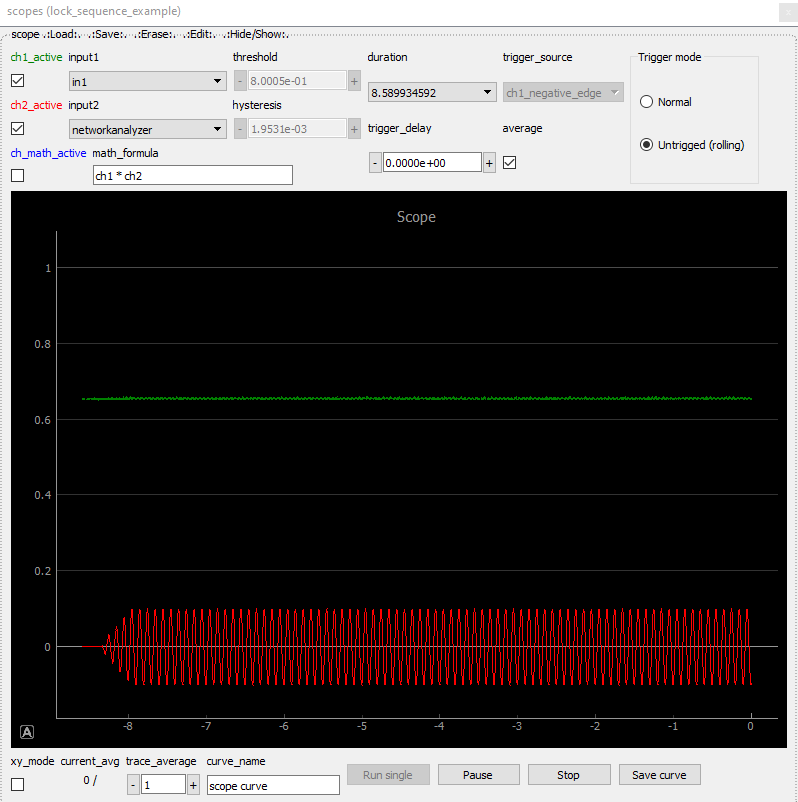

## Plot the actual Figure

C:\Users\Samuel\AppData\Local\Temp\ipykernel_1740\3224790915.py:132: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if background_correction=="delay":
C:\Users\Samuel\AppData\Local\Temp\ipykernel_1740\3224790915.py:27: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.2, top=0.93)


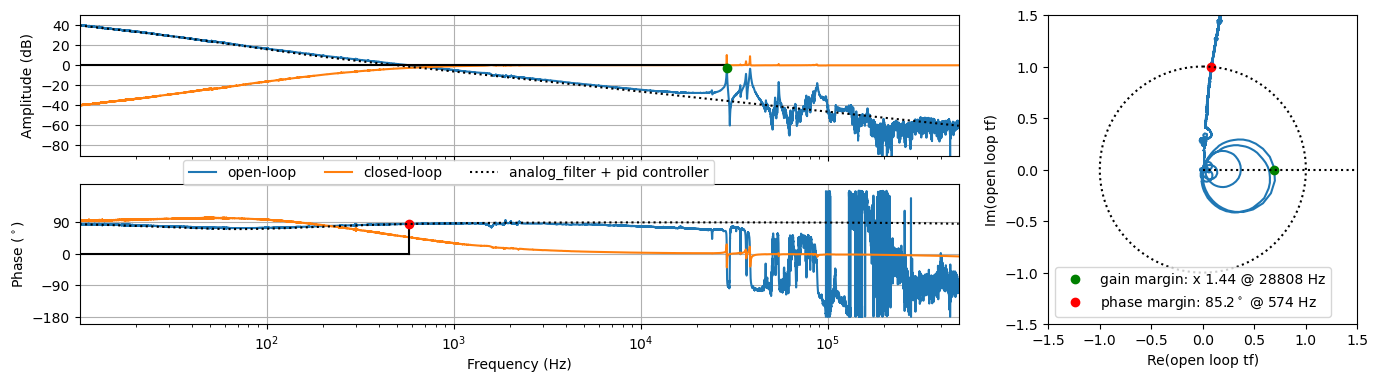

In [58]:
import h5py
# load data 
kwds = {}
with h5py.File("./data/data.h5", 'r') as f:
    for key in f.keys():
        kwds[key] = f[key][...]

fig = analyze_loop_tf(is_plot_plant=False, is_plot_controller=False, **kwds, nyquist_min_freq=200)        
ax_mag, ax_phase, ax_nyquist = fig.axes
ax_mag.set_xlim(min(kwds["freqs_tf"]), max(kwds["freqs_tf"]))
ax_mag.set_yticks([-80, -60, -40, -20, 0, 20, 40])
ax_mag.set_ylim(-90, 50)

cutoff_freq = 50
analog_filter_tf = 1/(1 + 1j*kwds["freqs_tf"]/cutoff_freq)
open_loop_tf, plant_tf = get_open_loop_and_plant(**kwds)
external_loop_gain = -np.abs(open_loop_tf[10]/kwds["controller_tf"][10]) # avoid first point which is affected by filter loading
bode_plot(kwds["freqs_tf"], external_loop_gain*kwds["controller_tf"]*analog_filter_tf, 
          axes=(ax_mag, ax_phase), linestyle=':', color='k', label="analog_filter + pid controller")
ax_mag.legend(ncol=3, bbox_to_anchor=(0.73, -0.26), loc='lower right')
plt.savefig("./figure_raw.pdf")

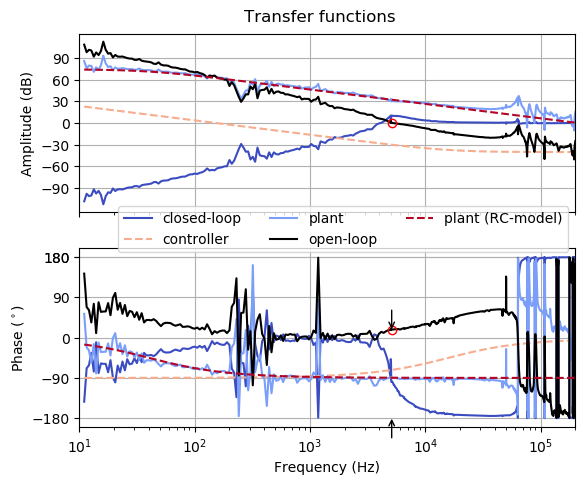

In [5]:
from pylab import plt, np

# Load data
freqs, zs, zpids = np.load(r"./data/freqs_zclosed_zpids_close.npy")
external_loop_gain = np.load(r"./data/external_loop_gain.npy")*0.5

DELAY_OUTPUT_TO_OUTPUT = 5*8e-9
zs = zs*np.exp(1j*2*np.pi*DELAY_OUTPUT_TO_OUTPUT*freqs)

# Customize matplotlib style
plt.style.use('default')
plt.style.use('seaborn-deep')

# Redefine bode_plot in case the cells above have not been executed
def bode_plot(freqs, zs, axes=None, label=None, color=None, linestyle=None):
    """
    Plots the magnitude and phase of a complex series.
    """
    if axes is None:
        fig, axes = plt.subplots(2, 1, sharex=True)
    axes[0].semilogx(freqs, 20*np.log10(np.abs(zs)), linestyle=linestyle, color=color, label=label)
    axes[1].semilogx(freqs, 180/np.pi*np.angle(zs), linestyle=linestyle, color=color, label=label)
    axes[0].set_xlim(10, 2e5)
    axes[1].set_ylim(-200, 200)
    axes[1].set_xlabel("Frequency (Hz)")
    axes[0].set_ylabel("Amplitude (dB)")
    axes[1].set_ylabel(r"Phase ($^\circ$)")

    axes[0].set_yticks([-90, -60, -30, 0, 30, 60, 90])
    axes[1].set_yticks([-180, -90, 0, 90, 180, 180])
    axes[0].tick_params(axis='x', which='minor', bottom=True)
    axes[1].tick_params(axis='x', which='minor', bottom=True)
    axes[0].grid(True)
    axes[1].grid(True)
    plt.subplots_adjust(hspace=0.2, top=0.93)
    return axes

# Exclude first point
freqs = np.real(freqs[1:])
zs = zs[1:]
zpids = zpids[1:]

# Choose line colors from colormap
CMAP = plt.cm.coolwarm

# plot closed-loop transfer function
axes = bode_plot(freqs, -zs, label="closed-loop", color=CMAP(0.), linestyle='-')

# plot pid transfer-function
bode_plot(freqs, zpids, axes, label="controller", color=CMAP(.7), linestyle='--')

# plot plant transfer-function
plant = -(1-1/zs)/zpids
bode_plot(freqs, plant, axes, label="plant", color=CMAP(0.2), linestyle='-')

# plot open-loop transfer function
open_loop = (1-1/zs)
bode_plot(freqs, open_loop, axes, label="open-loop", color="k")

# plot RC-model plant transfer-function
freq0 = 40
plant_rc = external_loop_gain/(1+1j*freqs/freq0)
bode_plot(freqs, plant_rc, axes=axes, color=CMAP(1.), label='plant (RC-model)', linestyle='--')
plt.suptitle("Transfer functions")


# find the open-loop unit-gain frequency
index_0db = (np.abs(open_loop)<1).nonzero()[0][0]
freq_0db = freqs[index_0db]
angle_0db = 180/np.pi*np.angle(open_loop[index_0db])

# plot a red marker on the unit-gain point
axes[0].plot([freq_0db], [0], 'or', markerfacecolor='None')
axes[1].plot([freq_0db], [angle_0db], 'or', markerfacecolor='None')

# Add a double-arrow to indicate the phase margin
axes[1].annotate('', xy=(freq_0db, angle_0db - 5), xytext=(freq_0db, angle_0db + 50), arrowprops=dict(arrowstyle='->'))
axes[1].annotate('', xy=(freq_0db, -180 + 5), xytext=(freq_0db, -180-50), arrowprops=dict(arrowstyle='->'))

# Add plot legend
axes[0].legend(ncol=3, bbox_to_anchor=(1., -0.26), loc='lower right')
axes[0].set_zorder(100)

plt.savefig("./figure_loop_tf.pdf")

## Deduce the piezo transfer function

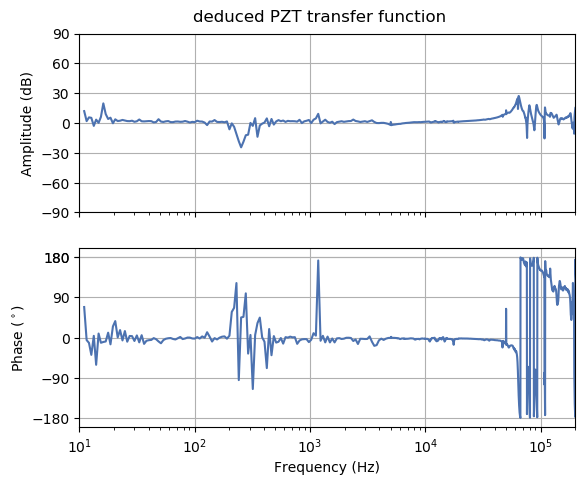

In [6]:
piezo = plant/plant_rc
axes = bode_plot(freqs, piezo, label='residual (PZT response)')
plt.suptitle("deduced PZT transfer function")

np.save("./data/freqs_piezo.npy", (freqs, piezo))